<a href="https://colab.research.google.com/github/elifsare/Realtime-Emotion-Recognition/blob/main/Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google colab connect drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


Pulling data from Kaggle to Google Colab

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elifsare","key":"65fe5c557a5858f538b76c194afd0b9a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ahmedmoorsy/facial-expression

 92% 177M/193M [00:03<00:00, 65.1MB/s]
100% 193M/193M [00:03<00:00, 56.3MB/s]


In [5]:
!mkdir face_dataset
!unzip '/content/facial-expression.zip' -d face_dataset

Archive:  /content/facial-expression.zip
  inflating: face_dataset/fer2013.csv  
  inflating: face_dataset/fer2013/fer2013.csv  


Importing Libraries

In [6]:
import pandas as pd                       
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 

from keras.models import Sequential     
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Dropout, AveragePooling2D, Activation
from keras.optimizers import SGD, Adam      
from keras.utils import np_utils  
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [7]:
data  = pd.read_csv('/content/face_dataset/fer2013.csv')
data .head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [9]:
train_data = data[data.Usage == "Training"]

In [10]:
# train sette örneklerin pikselleri tablo halinde biz liste yapıyoruz boşluklardan parse ederek
train_pixels = train_data.pixels.str.split(" ").tolist()

In [11]:
train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_img = train_pixels.values
train_img = train_img.astype(np.float)

print(train_img)
print(train_img.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


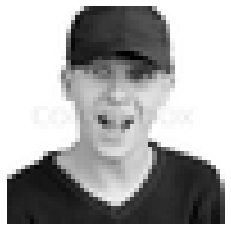

In [12]:
# reshape 48x48
def show(img):
  show_img = img.reshape(48,48)
  plt.axis('off')
  plt.imshow(show_img, cmap = 'gray')

show(train_img[55])

Test verisi ön işleme

In [13]:
# test piksellerini de düzenleyerek matris haline getiriyoruz
test_data = data[data.Usage == 'PublicTest']
test_pixels = test_data.pixels.str.split(" ").tolist()
test_pixels = pd.DataFrame(test_pixels, dtype = int)
test_img = test_pixels.values
test_img = test_img.astype(np.float)

print(test_img.shape)

(3589, 2304)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


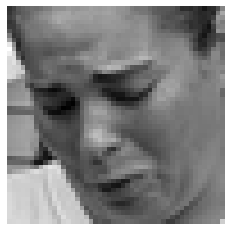

In [14]:
show(test_img[3001])

In [15]:
with open('/content/face_dataset/fer2013.csv') as f:
    content = f.readlines()

lines = np.array(content)
num_of_instances = lines.size

print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


In [17]:
X_train = []      #train pixels
y_train = []      #train labels
X_test = []       #test pixels
y_test = []       #test label

num_classes = 7
# Test ve eğitim verisinin transfer edilmesi
for i in range(1, num_of_instances):
    
    emotion, img, usage = lines[i].split(",")
      
    val = img.split(" ")
        
    pixels = np.array(val, 'float32')
         
    emotion = tf.keras.utils.to_categorical(emotion, num_classes)
    
    if 'Training' in usage:
        y_train.append(emotion)
        X_train.append(pixels)

    elif 'PublicTest' in usage:
        y_test.append(emotion)
        X_test.append(pixels)

In [18]:
# Eğtitim ve test kümelerinin diziye tranformasyonu
X_train = np.array(X_train, 'float32')
y_train = np.array(y_train, 'float32')
X_test = np.array(X_test, 'float32')
y_test = np.array(y_test, 'float32')

X_train /= 255 # [0, 1] aralığına normalize etme işlemi
X_test /= 255

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_train = X_train.astype('float32')
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
X_test = X_test.astype('float32')

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

28709 train samples
3589 test samples


In [19]:
#Batch (Küme) işlemleri
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 100
epochs = 50

gen = ImageDataGenerator()
train_generator = gen.flow(X_train, 
                           y_train,
                           batch_size=batch_size,
                           shuffle=True
                           )
train_generator.fit(X_train)

test_generator = gen.flow(X_test, 
                           y_test,
                           batch_size=batch_size,
                           shuffle=False
                           )

In [21]:
model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
# CheckPoint
root = '/content/drive/MyDrive/DeepLearningProject/EmotionDetection/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model1.h5', verbose = 1, save_best_only = True)

In [23]:
# overfitting engelliyoruz
# EarlyStop
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=15,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [24]:
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=batch_size,
                                epochs=epochs,
                                validation_data = test_generator,
                                validation_steps = test_generator.n//test_generator.batch_size,
                                callbacks=callbacks_list,
                                shuffle = True,
                                verbose=1
                              )

model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("/content/drive/MyDrive/DeepLearningProject/EmotionDetection/model1.h5")

  model.save('/content/drive/MyDrive/DeepLearningProject/EmotionDetection/model1.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 1.9769 - accuracy: 0.2398
Epoch 1: val_loss improved from inf to 1.91039, saving model to /content/drive/MyDrive/DeepLearningProject/EmotionDetection/checkPoint_model1.h5
100/100 [==============================] - 19s 83ms/step - loss: 1.9769 - accuracy: 0.2398 - val_loss: 1.9104 - val_accuracy: 0.2389 - lr: 0.0010
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 1.7734 - accuracy: 0.3104
Epoch 2: val_loss did not improve from 1.91039
100/100 [==============================] - 5s 47ms/step - loss: 1.7718 - accuracy: 0.3110 - val_loss: 2.1275 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 1.5952 - accuracy: 0.3823
Epoch 3: val_loss did not improve from 1.91039
100/100 [==============================] - 4s 43ms/step - loss: 1.5944 - accuracy: 0.3829 - val_loss: 1.9931 - val_accuracy: 0.2720 - lr: 0.0010
Epoch 4/50
 99/100 [=================

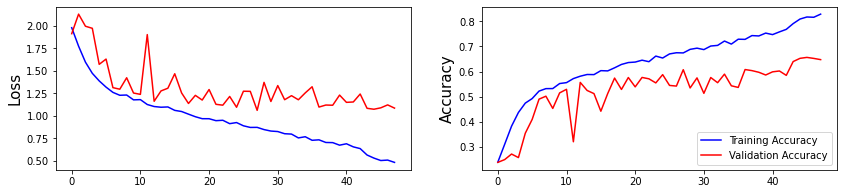

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,3))
plt.subplot(1,2,1)
#plt.suptitle('Train', fonstsize = 10)
plt.ylabel('Loss', fontsize = 15)
plt.plot(history.history['loss'], color = 'b', label = 'Training Loss')
plt.plot(history.history['val_loss'], color = 'r', label = 'Validation Loss')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize = 15)
plt.plot(history.history['accuracy'], color = 'b', label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

plt.legend(loc = 'lower right')

plt.show()

In [28]:
y_pred = model.predict(X_test)

113/113 [==============================] - 1s 8ms/step
[[4.3401903e-01 4.2836550e-03 1.0642976e-01 ... 3.1467374e-02
  2.0296514e-02 3.8818955e-01]
 [3.1823948e-02 1.4570019e-02 1.0800962e-02 ... 2.2202393e-02
  8.6486842e-03 7.6712266e-02]
 [6.5670401e-01 1.8413931e-02 3.5244241e-02 ... 1.6675998e-01
  1.7882101e-03 1.2084463e-01]
 ...
 [1.9553171e-02 7.9481331e-05 5.7298746e-02 ... 6.4356826e-02
  1.0289078e-02 6.6111648e-01]
 [5.2110630e-01 8.9238689e-04 8.1080325e-02 ... 2.2439392e-01
  5.1491880e-03 1.6693456e-01]
 [1.9360445e-02 7.6552984e-05 5.2265204e-02 ... 3.2188460e-01
  1.3638478e-03 5.9368694e-01]]


In [27]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

113/113 [==============================] - 1s 5ms/step
[[231  21  38  35  55  15  72]
 [  9  29   2   4   3   0   9]
 [ 49   4 165  34 112  51  81]
 [ 18   2  13 758  13  15  76]
 [ 78   1  56  49 285  12 172]
 [  6   2  21  32   9 328  17]
 [ 40   0  39  59  79   8 382]]
